In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
epochs = 50
model_id = 0

In [3]:
target_feature = "衣服長度 Clothes Length"
print("target feature:", target_feature)

target feature: 衣服長度 Clothes Length


In [4]:
from PIL import Image


def validate_image(row):
    filepath = row["filepath"]
    try:
        # Try to open the image file
        with Image.open(filepath) as img:
            img.verify()  # Check if the file is a valid image
        return True
    except (IOError, OSError):
        # If the image is not valid, return False
        return False

In [6]:
# Load the CSV file
csv_file = "./processed.csv"
df = pd.read_csv(csv_file)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Base directory where the images are stored
image_dir = "./clothes_data"

# Add the full path to each image
df["filepath"] = df["照片 Picture"].apply(lambda x: os.path.join(image_dir, f"{x}"))

df["衣服長度 Clothes Length"] = (df["衣服長度 Clothes Length"] == "長 long").astype(int)

# remove invalid datas
df = df[df.apply(validate_image, axis=1)].reset_index(drop=True)
# take % 10 == 0's data as test so remove them
df = df.drop(df.index[df.index % 10 == 0])

df["result"] = df[target_feature]
print(df)

print("total data:", len(df.index))

           照片 Picture 品牌 Brand  衣服長度 Clothes Length  價格 Price  毛衣、針織衣 Sweater  \
1     image_00001.jpg      H&M                    1       999             0.0   
2     image_00002.jpg      H&M                    1       699             0.0   
3     image_00003.jpg      H&M                    1       999             0.0   
4     image_00004.jpg      H&M                    1       699             0.0   
5     image_00005.jpg      H&M                    0       499             0.0   
...               ...      ...                  ...       ...             ...   
3589  image_03589.jpg    Lativ                    0       499             0.0   
3591  image_03591.jpg    Lativ                    0       499             0.0   
3592  image_03592.jpg    Lativ                    0       399             0.0   
3593  image_03593.jpg    Lativ                    0       499             0.0   
3594  image_03594.jpg    Lativ                    0       299             0.0   

      緊身褲 leggings  牛仔褲/裙 j

In [7]:
img_height, img_width = 180, 180


def load_and_preprocess_image(filepath):
    img = load_img(filepath, target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    return img_array

In [8]:
from sklearn.model_selection import train_test_split

# Split the dataframe into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Extract features and labels
train_images = np.array([load_and_preprocess_image(fp) for fp in train_df["filepath"]])
train_labels = train_df["result"].values

val_images = np.array([load_and_preprocess_image(fp) for fp in val_df["filepath"]])
val_labels = val_df["result"].values

In [9]:
model = models.Sequential(
    [
        layers.Input(shape=(img_height, img_width, 3)),
        layers.Conv2D(
            32, (3, 3), activation="relu", input_shape=(img_height, img_width, 3)
        ),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid"),  # Sigmoid for binary classification
    ]
)

C:\Users\doo12\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(
    train_images, train_labels, validation_data=(val_images, val_labels), epochs=epochs
)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.6342 - loss: 0.7869 - val_accuracy: 0.8238 - val_loss: 0.4565
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.8162 - loss: 0.4273 - val_accuracy: 0.8022 - val_loss: 0.4336
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8492 - loss: 0.3611

In [ ]:
loss, accuracy = model.evaluate(val_images, val_labels)
name = "model_length_" + str(model_id) + ".keras"


print(f"{name}: {accuracy:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9979 - loss: 0.0051
model_feature_3_0.keras: 0.9969


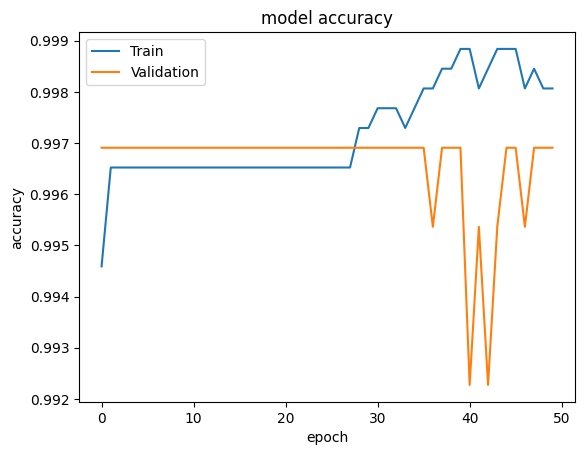

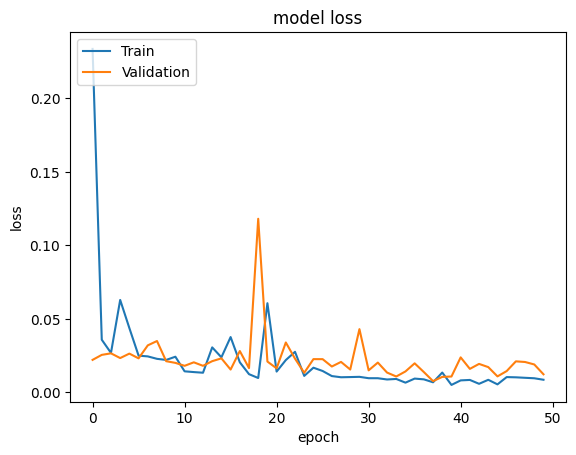

In [59]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()
# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [60]:
model_folder = "models"
model.save(os.path.join(model_folder, name))